In [ ]:
# 1. import module

from py_module.compare import *
from py_module.etc import *
from py_module.verify import *
from py_module.pre_processing import *
from py_module.regression import *
from py_module.plot_data import plot_histogram
from py_module.load_data import load_data
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pycaret.regression import *

from sklearn.model_selection import train_test_split
from sklearn import metrics
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None

In [ ]:

raw_data = pd.read_csv(
    "Y:\Autosimul_data\OBC_transformer\\output_data.csv", delimiter=",")
raw_data.head()

pd_data = raw_data
pd_data = pd_data.dropna()
pd_data = pd_data.sort_values(by='B_top_left')
print(f'필터링 전 : {pd_data.shape}')
tx_ratio = pd_data["Tx_positions"].str.split(
    ",").apply(len) / pd_data["Tx_turns"]
rx_ratio = pd_data["Rx_positions"].str.split(
    ",").apply(len) / pd_data["Rx_turns"]

# Rx_turns 열 바로 다음(= 인덱스 3 위치)에 두 컬럼 삽입
pd_data.insert(loc=pd_data.columns.get_loc("Rx_turns") + 1,
               column="Tx_ratio", value=tx_ratio)
pd_data.insert(loc=pd_data.columns.get_loc("Rx_turns") + 2,
               column="Rx_ratio", value=rx_ratio)

# ── ② 포지션 문자열에서 쉼표(,) 제거 ───────────────────────────────
pd_data["Tx_positions"] = pd_data["Tx_positions"].str.replace(
    ",", "", regex=False)
pd_data["Rx_positions"] = pd_data["Rx_positions"].str.replace(
    ",", "", regex=False)

pd_data.head()
# 결과 확인


# print(f'필터링 전 : {pd_data.shape}')
# pd_data = pd_data[~pd_data.duplicated(subset=['copperloss_Tx_80kHz'], keep=False)]
# print(f'필터링 후 : {pd_data.shape}')

필터링 전 : (5138, 44)


,core_name,Tx_turns,Rx_turns,Tx_ratio,Rx_ratio,Tx_positions,Rx_positions,w1,l1_leg,l1_center,l2,h1,l1_top,g1,g2,Tx_coil_width,Rx_coil_width,coil_height,space_height,Tx_space_x,Tx_space_y,Rx_space_x,Rx_space_y,move_z,via_space,magnetizing_current,Ltx,Lrx,M,k,Lmt,Lmr,Llt,Llr,copperloss_Tx,copperloss_Rx,coreloss,B_core,B_left,B_right,B_center,B_top_left,B_bottom_left,B_top_right,B_bottom_right,resonance_frequency
9,E80_38_20 * 1,7,9,0.714286,0.333333,34567,012,19.8,9.9,19.8,20.2,56.4,9.9,0.0,0.04,15.7,18.1,0.070,0.2,4.4,3.6,4.7,0.2,-0.3,0.3,2.447766,60.2743,21.6733,35.9917,0.9958,59.7693,21.4918,0.5049,0.1816,8.7288,8.8117,77.0146,0.0715,0.0001,0.1335,0.0686,0.0011,0.0012,0.1486,0.1545,0.99541
1322,E80_38_20 * 1,6,8,0.333333,0.625000,34,01256,19.8,9.9,19.8,20.2,56.4,9.9,0.0,0.33,16.8,11.8,0.035,0.4,0.4,2.2,0.4,0.2,-0.6,0.4,75.189768,2.1254,12.8758,5.0053,0.9568,1.9458,11.7875,0.1796,1.0883,9.7856,16.3317,805.4360,0.1860,0.0030,0.3415,0.1719,0.0020,0.0032,0.3782,0.3836,4.78630
692,E80_38_20 * 1,6,8,0.333333,0.625000,06,12345,19.8,9.9,19.8,20.2,56.4,9.9,0.0,0.14,16.6,12.4,0.105,0.3,0.9,2.8,2.7,4.4,-0.0,0.2,36.328142,4.2082,26.0437,10.2413,0.9783,4.0272,24.9236,0.1810,1.1201,6.4054,4.7578,753.9240,0.1807,0.0015,0.3450,0.1741,0.0020,0.0026,0.3733,0.3741,1.93197
2349,E80_38_20 * 1,7,9,0.428571,0.555556,045,12367,19.8,9.9,19.8,20.2,56.4,9.9,0.0,0.14,15.9,9.7,0.070,0.3,3.2,1.5,3.8,2.7,-0.7,0.1,15.787909,9.4404,26.3085,15.6138,0.9908,9.2667,25.8243,0.1737,0.4841,7.4818,6.7364,269.2040,0.1185,0.0008,0.2277,0.1102,0.0021,0.0018,0.2449,0.2462,1.77828
2978,E80_38_20 * 1,8,11,0.375000,0.545455,016,234578,19.8,9.9,19.8,20.2,56.4,9.9,0.0,0.20,18.4,9.0,0.035,0.2,3.3,1.3,0.5,4.1,0.2,0.5,21.693647,6.9460,28.0604,13.7564,0.9854,6.7440,27.2444,0.2020,0.8160,23.8053,21.0452,276.3110,0.1194,0.0007,0.2329,0.1150,0.0021,0.0018,0.2465,0.2468,2.12814


In [ ]:
# column_names =  ["none","w1","l1_leg","l1_top","l2","h1","l1_center","Tx_turns","Tx_width","Tx_height","Tx_space_x","Tx_space_y","Tx_preg","g1","g2","g3",
#                  "Tx_layer_space_x","Tx_layer_space_y","Ltx","copperloss_Tx","coreloss","B_core","B_left","B_right","B_center","B_top_left","B_bottom_left","B_top_right",
#                  "B_bottom_right","copperloss_Tx_80kHz"]
# raw_data =  pd.read_csv("Y:\Autosimul_data\LGE_PFC_inductor\LGE_PFC_inductor_planar_2layer_v2_g2_0\\simulation_data_20250401_113649_N17920.csv",delimiter=",",names=column_names,header=None)
raw_data = pd.read_csv(
  "Y:\Autosimul_data\OBC_transformer\\output_data.csv", delimiter=",")
raw_data.head()
# '(width_ratio)*l2*ratio/({math.ceil(self.pri_turns/2)})
# 2. one-click
pd_data = raw_data
# pd_data = pd_data[pd_data['copperloss_Tx_80kHz'] <= 25]

print(f'필터링 전 : {pd_data.shape}')

# pd_data.drop("none",axis=1,inplace=True)


pd_data = pd_data[pd_data['magnetizing_current'] < 250]
tx_ratio = pd_data["Tx_positions"].str.split(
  ",").apply(len) / pd_data["Tx_turns"]
rx_ratio = pd_data["Rx_positions"].str.split(
  ",").apply(len) / pd_data["Rx_turns"]

# Rx_turns 열 바로 다음(= 인덱스 3 위치)에 두 컬럼 삽입
pd_data.insert(loc=pd_data.columns.get_loc("Rx_turns") + 1,
               column="Tx_ratio", value=tx_ratio)
pd_data.insert(loc=pd_data.columns.get_loc("Rx_turns") + 2,
               column="Rx_ratio", value=rx_ratio)


# 쉼표 제거 후 정수로 바꿔 두면 select_dtypes 가 number 로 인식
pd_data["Tx_positions"] = pd.to_numeric(
    pd_data["Tx_positions"].str.replace(",", "", regex=False),
    errors="coerce"
)
pd_data["Rx_positions"] = pd.to_numeric(
    pd_data["Rx_positions"].str.replace(",", "", regex=False),
    errors="coerce"
)


pd_data.drop("core_name", axis=1, inplace=True)

pd_data.drop("magnetizing_current", axis=1, inplace=True)
pd_data.drop("Ltx", axis=1, inplace=True)
pd_data.drop("Lrx", axis=1, inplace=True)
pd_data.drop("M", axis=1, inplace=True)
pd_data.drop("k", axis=1, inplace=True)
pd_data.drop("Lmt", axis=1, inplace=True)
pd_data.drop("Lmr", axis=1, inplace=True)
pd_data.drop("Llt", axis=1, inplace=True)
pd_data.drop("Llr", axis=1, inplace=True)
pd_data.drop("copperloss_Tx", axis=1, inplace=True)
pd_data.drop("copperloss_Rx", axis=1, inplace=True)
pd_data.drop("coreloss", axis=1, inplace=True)


pd_data.drop("B_core", axis=1, inplace=True)
pd_data.drop("B_left", axis=1, inplace=True)
pd_data.drop("B_right", axis=1, inplace=True)
pd_data.drop("B_center", axis=1, inplace=True)
pd_data.drop("B_top_left", axis=1, inplace=True)
pd_data.drop("B_top_right", axis=1, inplace=True)
pd_data.drop("B_bottom_left", axis=1, inplace=True)
pd_data.drop("B_bottom_right", axis=1, inplace=True)
# pd_data.drop("resonance_frequency",axis=1,inplace=True)


# pd_data['Llr1'] = pd_data['Llr1']/1000
#


# pd_data['Llr1'] = pd_data['Llr1']/1000
#


# pd_data = pd_data[pd_data['Llr']>0.2]
pd_data = pd_data.dropna()
pd_data.head()

# 7. define outlier search function


def get_outlier(df=None, column=None, weight=1.5):

  # column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  data = df[column]
  quantile_25 = np.percentile(data.values, 10)  # 1/4 분위
  quantile_75 = np.percentile(data.values, 90)  # 3/4 분위

  # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight  # 이상치 최소 기준
  highest_val = quantile_75 + iqr_weight  # 이상치 최대 기준

  # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환.
  outlier_index = data[(data < lowest_val) | (data > highest_val)].index

  return outlier_index


col_input = list(pd_data.columns)[:-2]
col_input = list(pd_data.columns)

# outlier 탐색 및 제거


outlier_index = {}
for i, colName in enumerate(col_input):
  outlier_index[i] = get_outlier(df=pd_data, column=f'{colName}', weight=1.5)
outlier_index

# 각각의 숫자들 리스트 안에 넣기
outlier_list = []
for i in range(len(outlier_index)):
  if list(outlier_index[i].values) == []:
    continue
  outlier_list.append(list(outlier_index[i].values))


# 리스트 안의 리스트들을 하나로 합치기
outlier_list = sum(outlier_list, [])
print('개수:', len(outlier_list))

# 중복 숫자 제거
outlier_list = set(outlier_list)
print('개수:', len(outlier_list))

# 다시 리스트 타입으로 변환
outlier_list = list(outlier_list)
print(type(outlier_list))

# 리스트 숫자 정렬
outlier_list.sort()

# outlier를 갖는 index에 해당하는 data drop
for i in outlier_list:
  pd_data.drop(i, axis=0, inplace=True)

print(f'필터링 후 : {pd_data.shape}')

# # split input/output

# count = (pd_data['coreloss'] <= 20).sum()
# print(count)

필터링 전 : (5143, 44)
개수: 589
개수: 557
<class 'list'>
필터링 후 : (4558, 25)


In [ ]:
# parameter = "B_top_left"
# parameter = "coreloss"
# parameter = "Lmt"
from pycaret.regression import *
parameter = "resonance_frequency"


X = pd_data.drop(columns=parameter)
Y = pd_data[parameter]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=885)

Z = pd.concat([X_train, Y_train], axis=1)


model = LGBMRegressor(random_state=765, n_estimators=10000, learning_rate=0.1,
                      num_leaves=15, max_depth=-1, objective="poisson", boosting_type="dart")
model.fit(X_train, Y_train)


print("start")

a = time.time()
# exp_reg101 = setup(data = Z, target = parameter, session_id=123, silent=True, use_gpu=False, remove_perfect_collinearity=False, numeric_features=["N1","N2"])
# model = ensemble_model(model, method = 'Boosting', n_estimators = 100)
print("done : ", time.time() - a)

print(model)

start
done :  0.0
LGBMRegressor(boosting_type='dart', n_estimators=10000, num_leaves=15,
              objective='poisson', random_state=765)


['./model/resonance_frequency_250723.pkl']

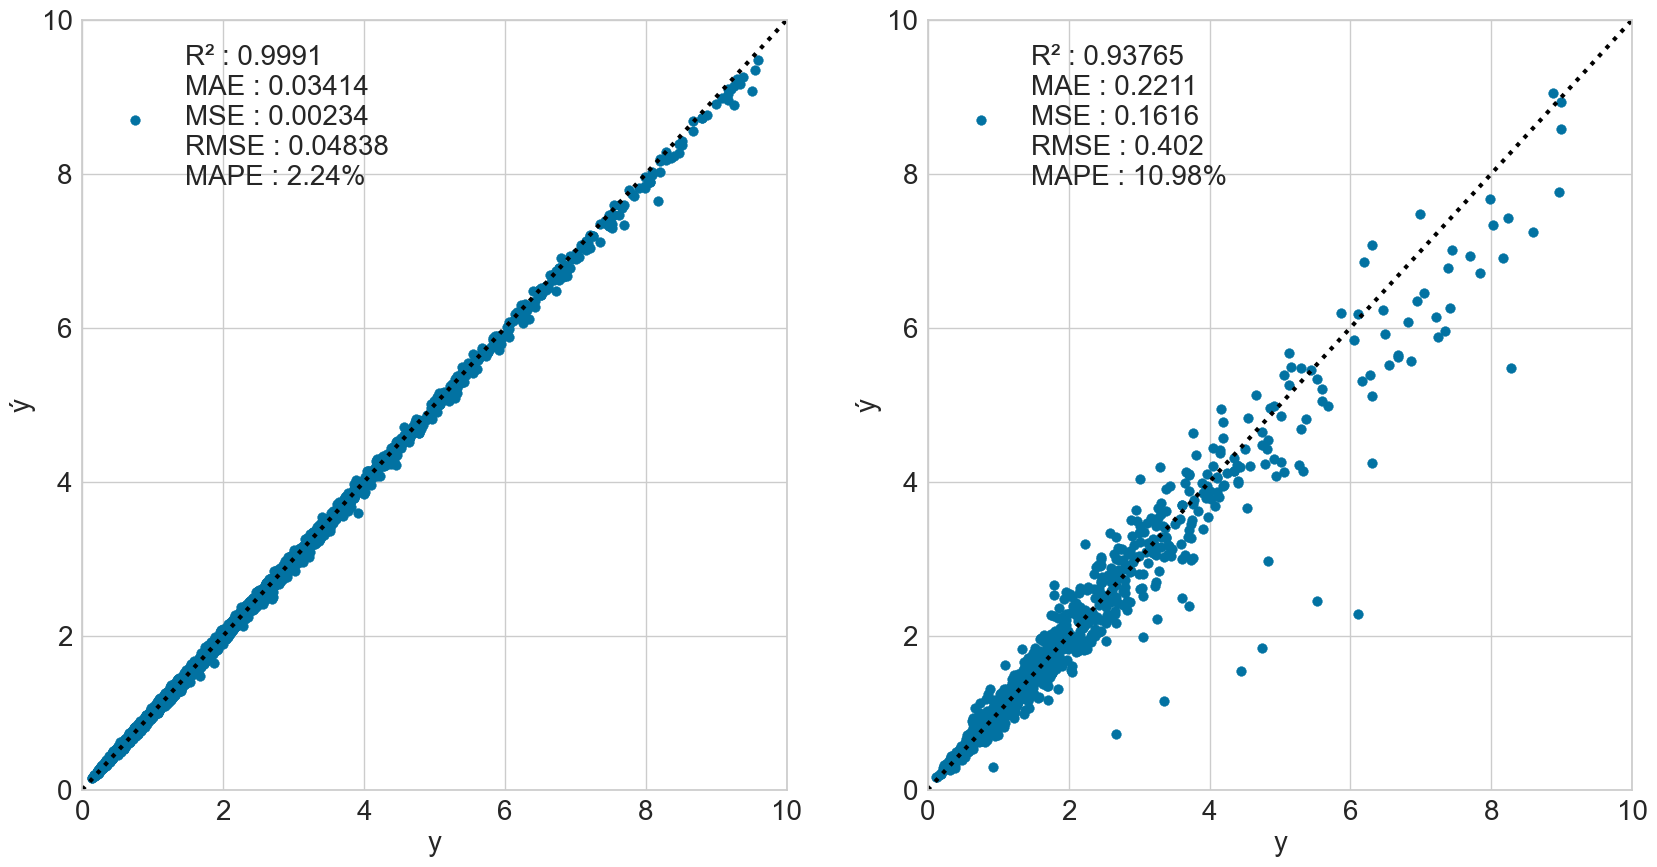

In [ ]:
import joblib
train_data = pd.concat([X_train, pd.DataFrame(Y_train)], axis=1)

test_data = pd.concat([X_test, pd.DataFrame(Y_test)], axis=1)


train_data.head()


verify_plot(model, train_data, test_data, parameter, xlim=[
            0, 10], ylim=[0, 10], legend=True, x_txt="", y_txt="")

date = 250723

joblib.dump(model, f'./model/{parameter}_{date}.pkl')

In [ ]:
temp = model.predict(X_test)

X_test_reset = X_test.reset_index(drop=True)
Y_test_reset = Y_test.reset_index(drop=True)

# 새로운 데이터프레임 temp2와 concat 시도

result = pd.concat([X_test_reset, Y_test_reset, pd.DataFrame(temp)], axis=1)
result_sorted = result.sort_values(by='resonance_frequency', ascending=True)
result_sorted

,Tx_turns,Rx_turns,Tx_ratio,Rx_ratio,Tx_positions,Rx_positions,w1,l1_leg,l1_center,l2,h1,l1_top,g1,g2,Tx_coil_width,Rx_coil_width,coil_height,space_height,Tx_space_x,Tx_space_y,Rx_space_x,Rx_space_y,move_z,via_space,resonance_frequency,0
227,8,11,0.500000,0.454545,136,24578,152.40,5.100,10.20,21.800,10.20,5.10,0.0,0.00,9.6,5.6,0.035,0.2,4.6,1.5,1.6,4.5,2.2,0.1,0.12078,0.166539
376,8,11,0.500000,0.454545,1358,2467,101.60,5.100,10.20,21.800,10.20,5.10,0.0,0.00,11.3,7.7,0.070,0.2,3.0,2.9,4.4,4.3,0.4,0.2,0.12589,0.165577
307,8,11,0.375000,0.545455,124,35678,152.40,5.100,10.20,21.800,10.20,5.10,0.0,0.07,12.3,13.0,0.105,0.2,1.6,1.4,2.9,0.7,-0.1,0.4,0.16144,0.196470
849,6,8,0.666667,0.375000,256,134,152.40,5.100,10.20,21.800,10.20,5.10,0.0,0.00,10.4,9.6,0.070,0.3,3.8,4.6,4.9,0.9,0.9,0.5,0.18281,0.205375
31,7,9,0.285714,0.666667,25,13467,152.40,5.100,10.20,21.800,10.20,5.10,0.0,0.02,14.5,14.0,0.105,0.3,4.8,3.7,3.1,1.7,0.9,0.2,0.19409,0.199583
593,8,11,0.500000,0.454545,1238,4567,152.40,5.100,10.20,21.800,10.20,5.10,0.0,0.14,17.3,19.1,0.035,0.2,3.9,3.6,2.6,2.6,0.3,0.2,0.19409,0.221086
752,8,11,0.500000,0.454545,367,12458,152.40,5.100,10.20,21.800,10.20,5.10,0.0,0.19,13.6,15.0,0.035,0.2,4.6,4.4,4.4,1.8,0.6,0.5,0.22182,0.281157
56,6,8,0.333333,0.625000,14,2356,152.40,5.100,10.20,21.800,10.20,5.10,0.0,0.06,16.9,16.7,0.035,0.2,0.2,2.3,1.0,3.5,0.7,0.5,0.22387,0.300793
812,8,11,0.500000,0.454545,2478,1356,59.40,9.900,19.80,20.200,56.40,9.90,0.0,0.08,17.4,18.0,0.070,0.2,3.6,0.8,0.4,1.6,-0.7,0.4,0.23768,0.320576
68,6,8,0.333333,0.625000,5,12346,101.60,5.100,10.20,21.800,10.20,5.10,0.0,0.00,11.6,15.2,0.070,0.3,0.5,3.0,3.9,2.1,-1.3,0.3,0.24660,0.284902


필터링 전 : (17455, 42)


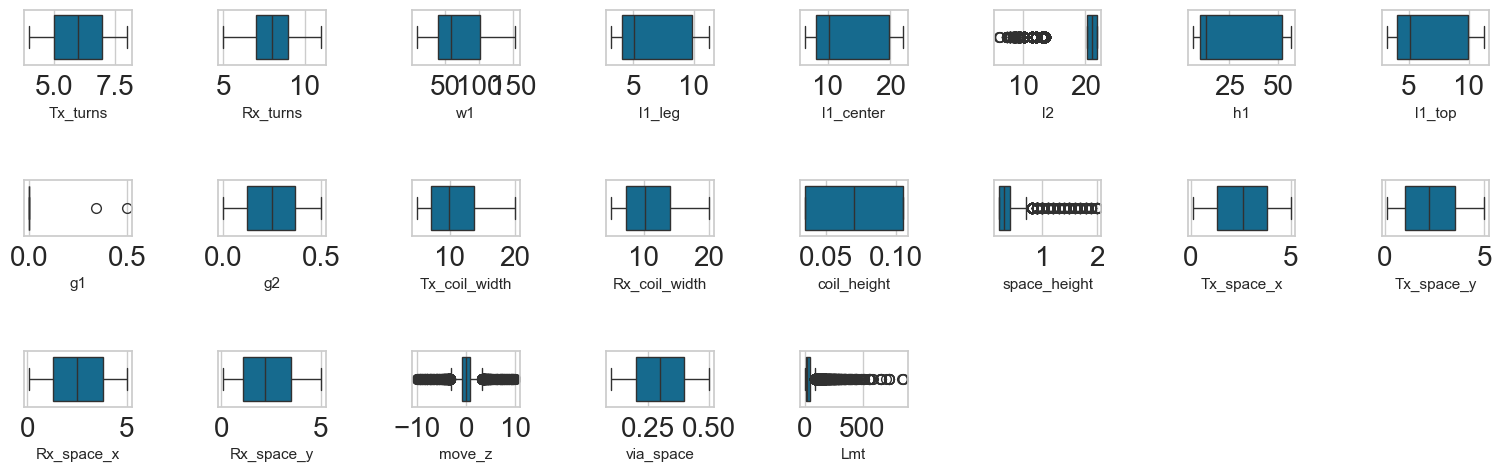

In [ ]:
raw_data = pd.read_csv(
  "Y:\Autosimul_data\OBC_transformer\\output_data.csv", delimiter=",")
raw_data.head()
# '(width_ratio)*l2*ratio/({math.ceil(self.pri_turns/2)})
# 2. one-click
pd_data = raw_data
# pd_data = pd_data[pd_data['copperloss_Tx_80kHz'] <= 25]

print(f'필터링 전 : {pd_data.shape}')

# pd_data.drop("none",axis=1,inplace=True)

# pd_data = pd_data[pd_data['B_top_left']<2]

pd_data.drop("core_name", axis=1, inplace=True)

pd_data.drop("magnetizing_current", axis=1, inplace=True)
pd_data.drop("Ltx", axis=1, inplace=True)
pd_data.drop("Lrx", axis=1, inplace=True)
pd_data.drop("M", axis=1, inplace=True)
pd_data.drop("k", axis=1, inplace=True)
# pd_data.drop("Lmt",axis=1,inplace=True)
pd_data.drop("Lmr", axis=1, inplace=True)
pd_data.drop("Llt", axis=1, inplace=True)
pd_data.drop("Llr", axis=1, inplace=True)
pd_data.drop("copperloss_Tx", axis=1, inplace=True)
pd_data.drop("copperloss_Rx", axis=1, inplace=True)
pd_data.drop("coreloss", axis=1, inplace=True)


pd_data.drop("B_core", axis=1, inplace=True)
pd_data.drop("B_left", axis=1, inplace=True)
pd_data.drop("B_right", axis=1, inplace=True)
pd_data.drop("B_center", axis=1, inplace=True)
pd_data.drop("B_top_left", axis=1, inplace=True)
pd_data.drop("B_top_right", axis=1, inplace=True)
pd_data.drop("B_bottom_left", axis=1, inplace=True)
pd_data.drop("B_bottom_right", axis=1, inplace=True)
pd_data.drop("resonance_frequency", axis=1, inplace=True)


plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)):
  plt.subplot(7, 8, i + 1)
  sns.boxplot(x=pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

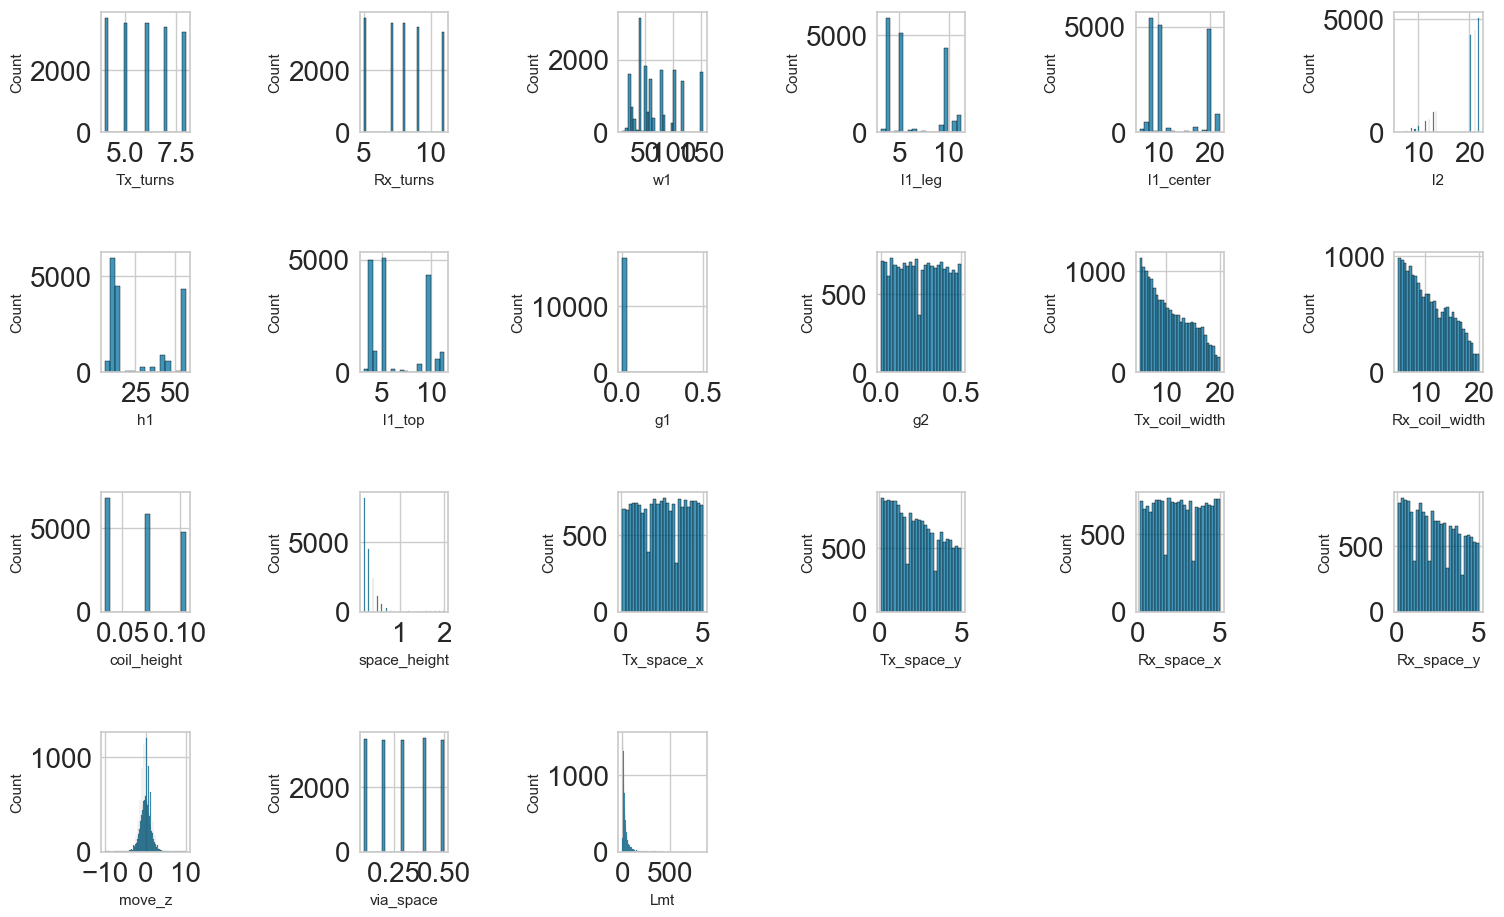

In [ ]:
plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)):
  plt.subplot(5, 6, i + 1)
  sns.histplot(pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

<Axes: >

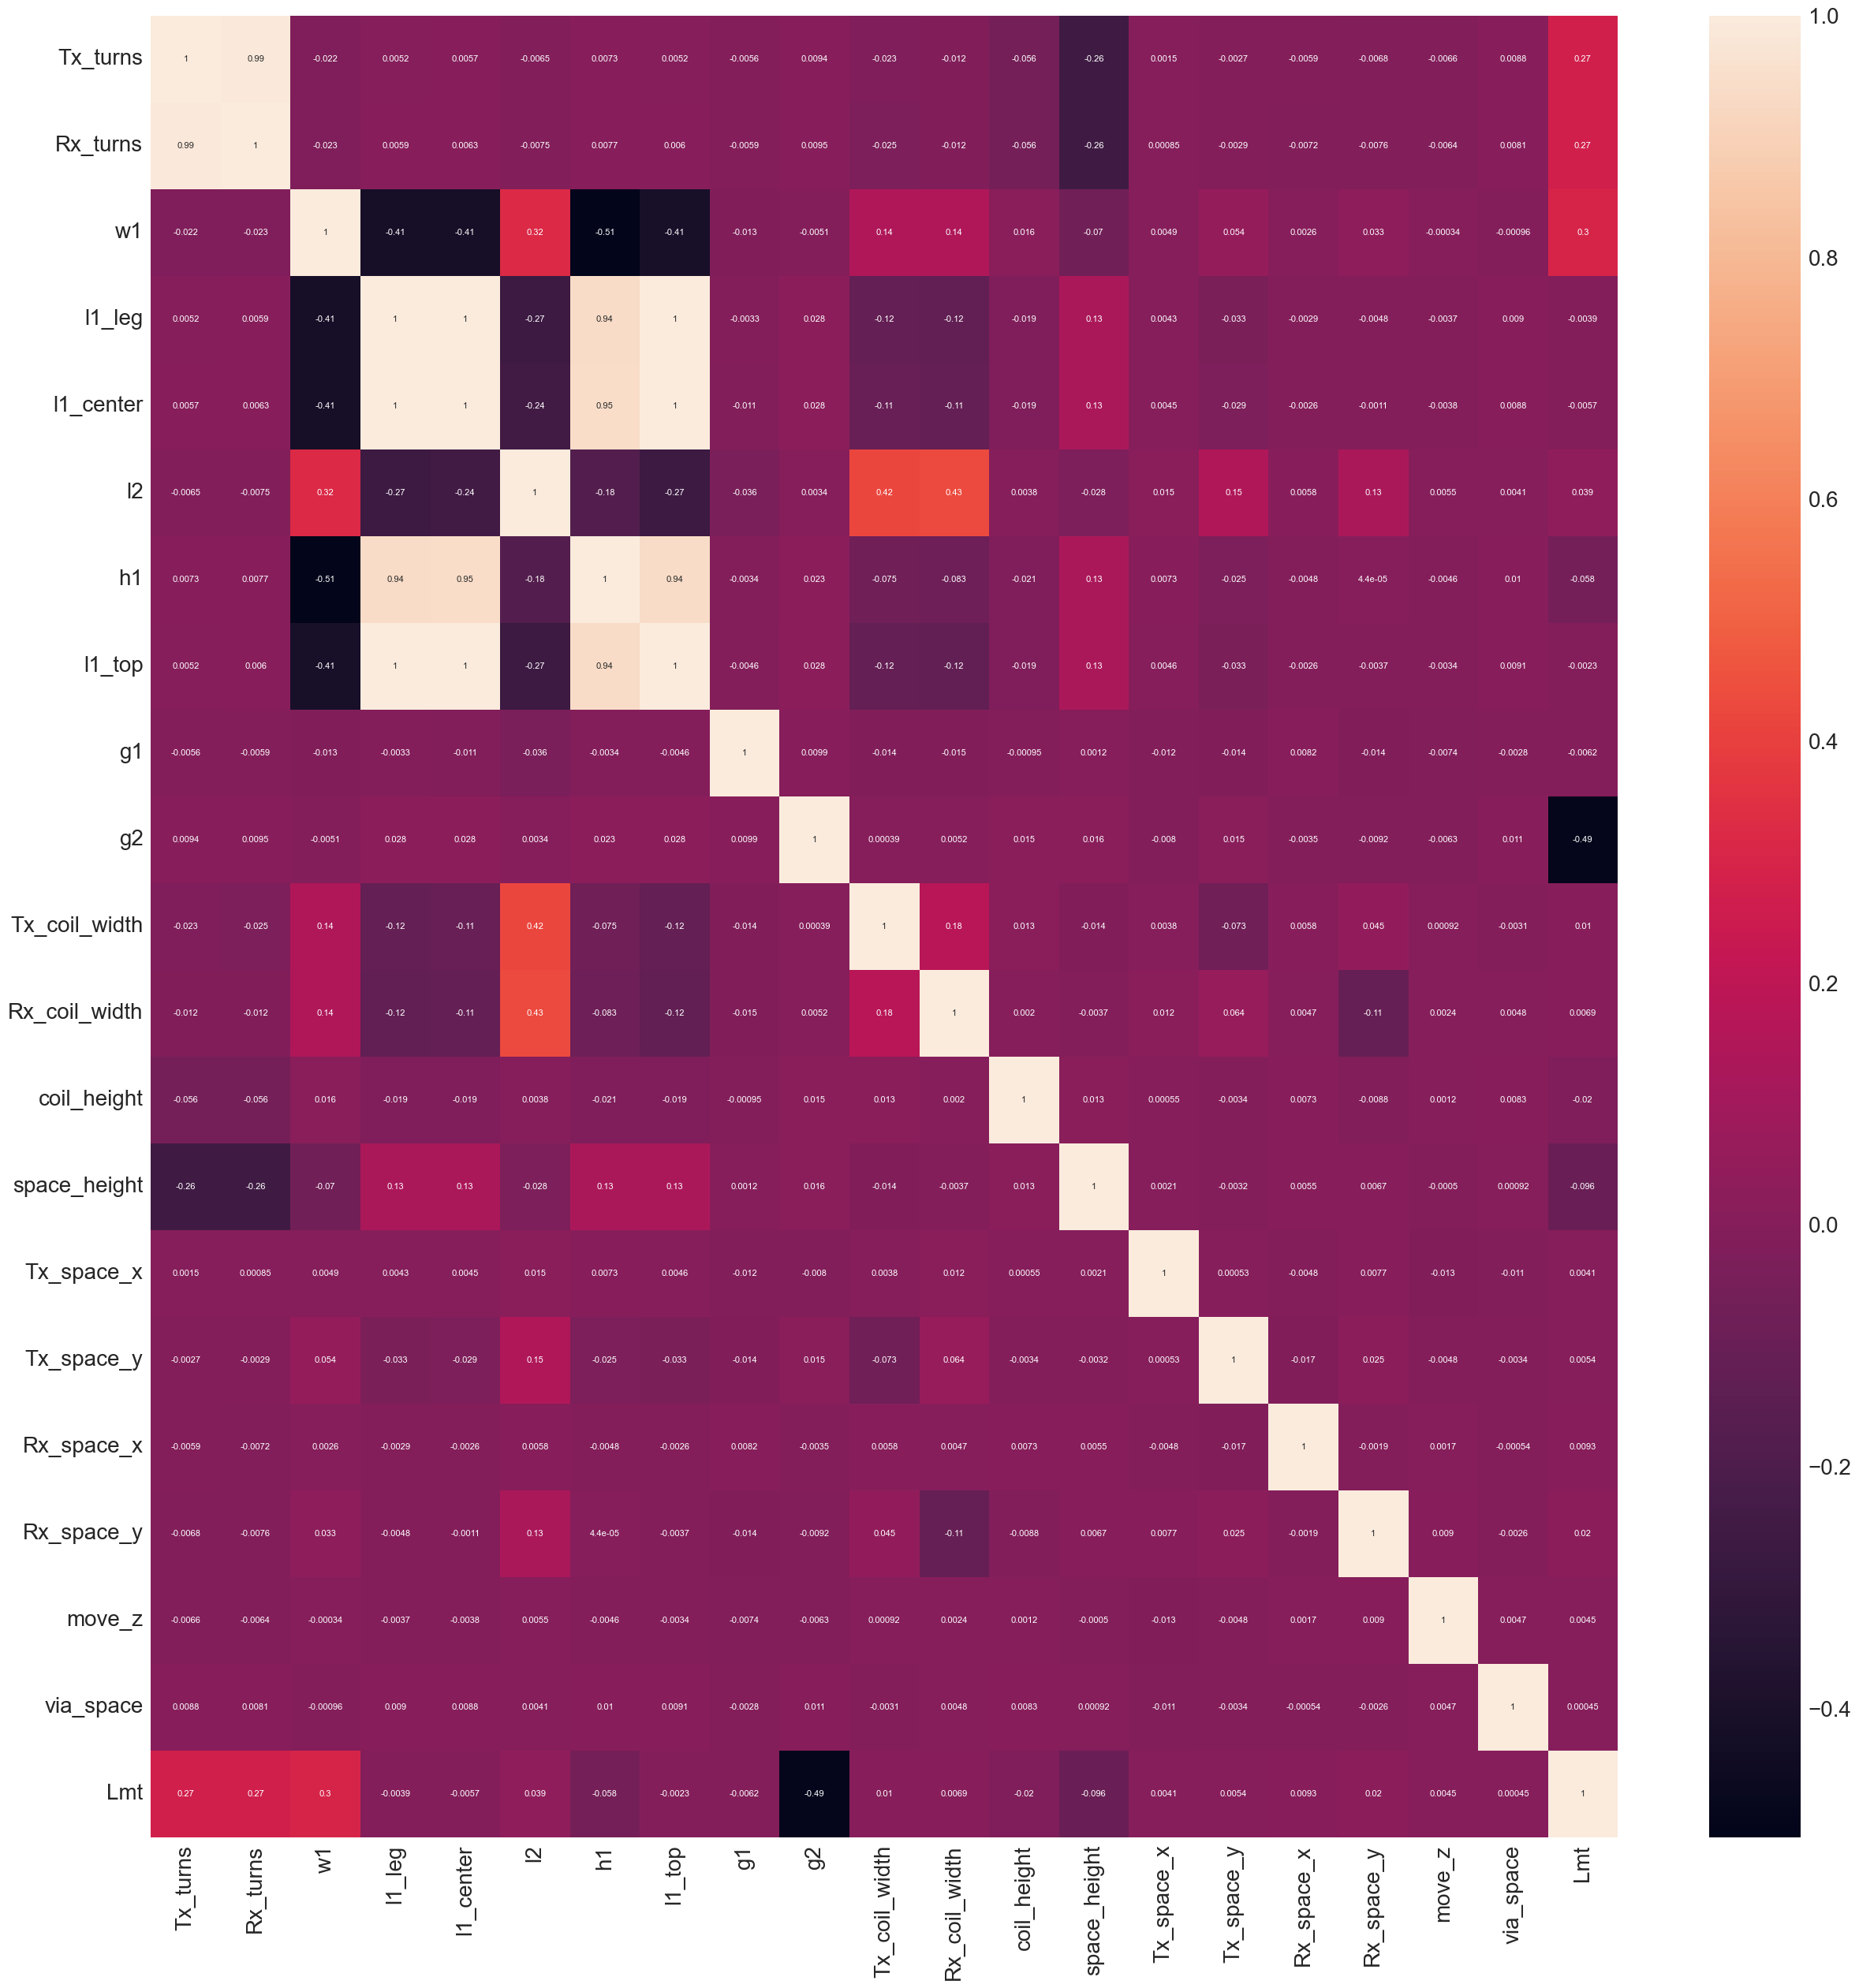

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(data=pd_data.corr(), annot=True, annot_kws={"size": 8})